In [211]:
import pandas as pd
import seaborn as sns
from seaborn import load_dataset
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt



In [212]:
df = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/train.csv')
df_test = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/test.csv')


In [213]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [214]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [216]:
df_copy = df.copy()

In [217]:
df = df.drop([ 'Cabin', 'Ticket'], axis=1)


In [218]:
df['Title'] = df['Name'].str.split(',').str[1].str.split('.').str[0].str.strip()

In [219]:
df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [220]:
title_counts = df['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Misc')


In [221]:
df['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64

In [222]:
df= df.drop(['Name'], axis=1)

In [223]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,male,22.0,1,0,7.2500,S,Mr
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs
2,3,1,3,female,26.0,0,0,7.9250,S,Miss
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs
4,5,0,3,male,35.0,0,0,8.0500,S,Mr


In [224]:
df.groupby('Sex')['Age'].mean()


Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

In [225]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [226]:
df['Age'] = df['Age'].fillna(df.groupby('Sex')['Age'].transform('mean'))
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [227]:
label_encoder = LabelEncoder()

df['Embarked_Code'] = label_encoder.fit_transform(df['Embarked'])
df['Sex_Code'] = label_encoder.fit_transform(df['Sex'])
df['Title_Code'] = label_encoder.fit_transform(df['Title'])


In [228]:
bin_ranges = [0, 5, 10, 15, 30, 40, 50, 60, 70, 80]  # Adjust the bin ranges as desired
labels = range(1, len(bin_ranges))  # Assign labels 1, 2, 3, 4, 5, and so on
df['Age_Bin'] = pd.cut(df['Age'], bins=bin_ranges, labels=labels).astype(int)

df['Fare_Bin'] = pd.qcut(df['Fare'], q=3, labels=[1, 2, 3]).astype(int)

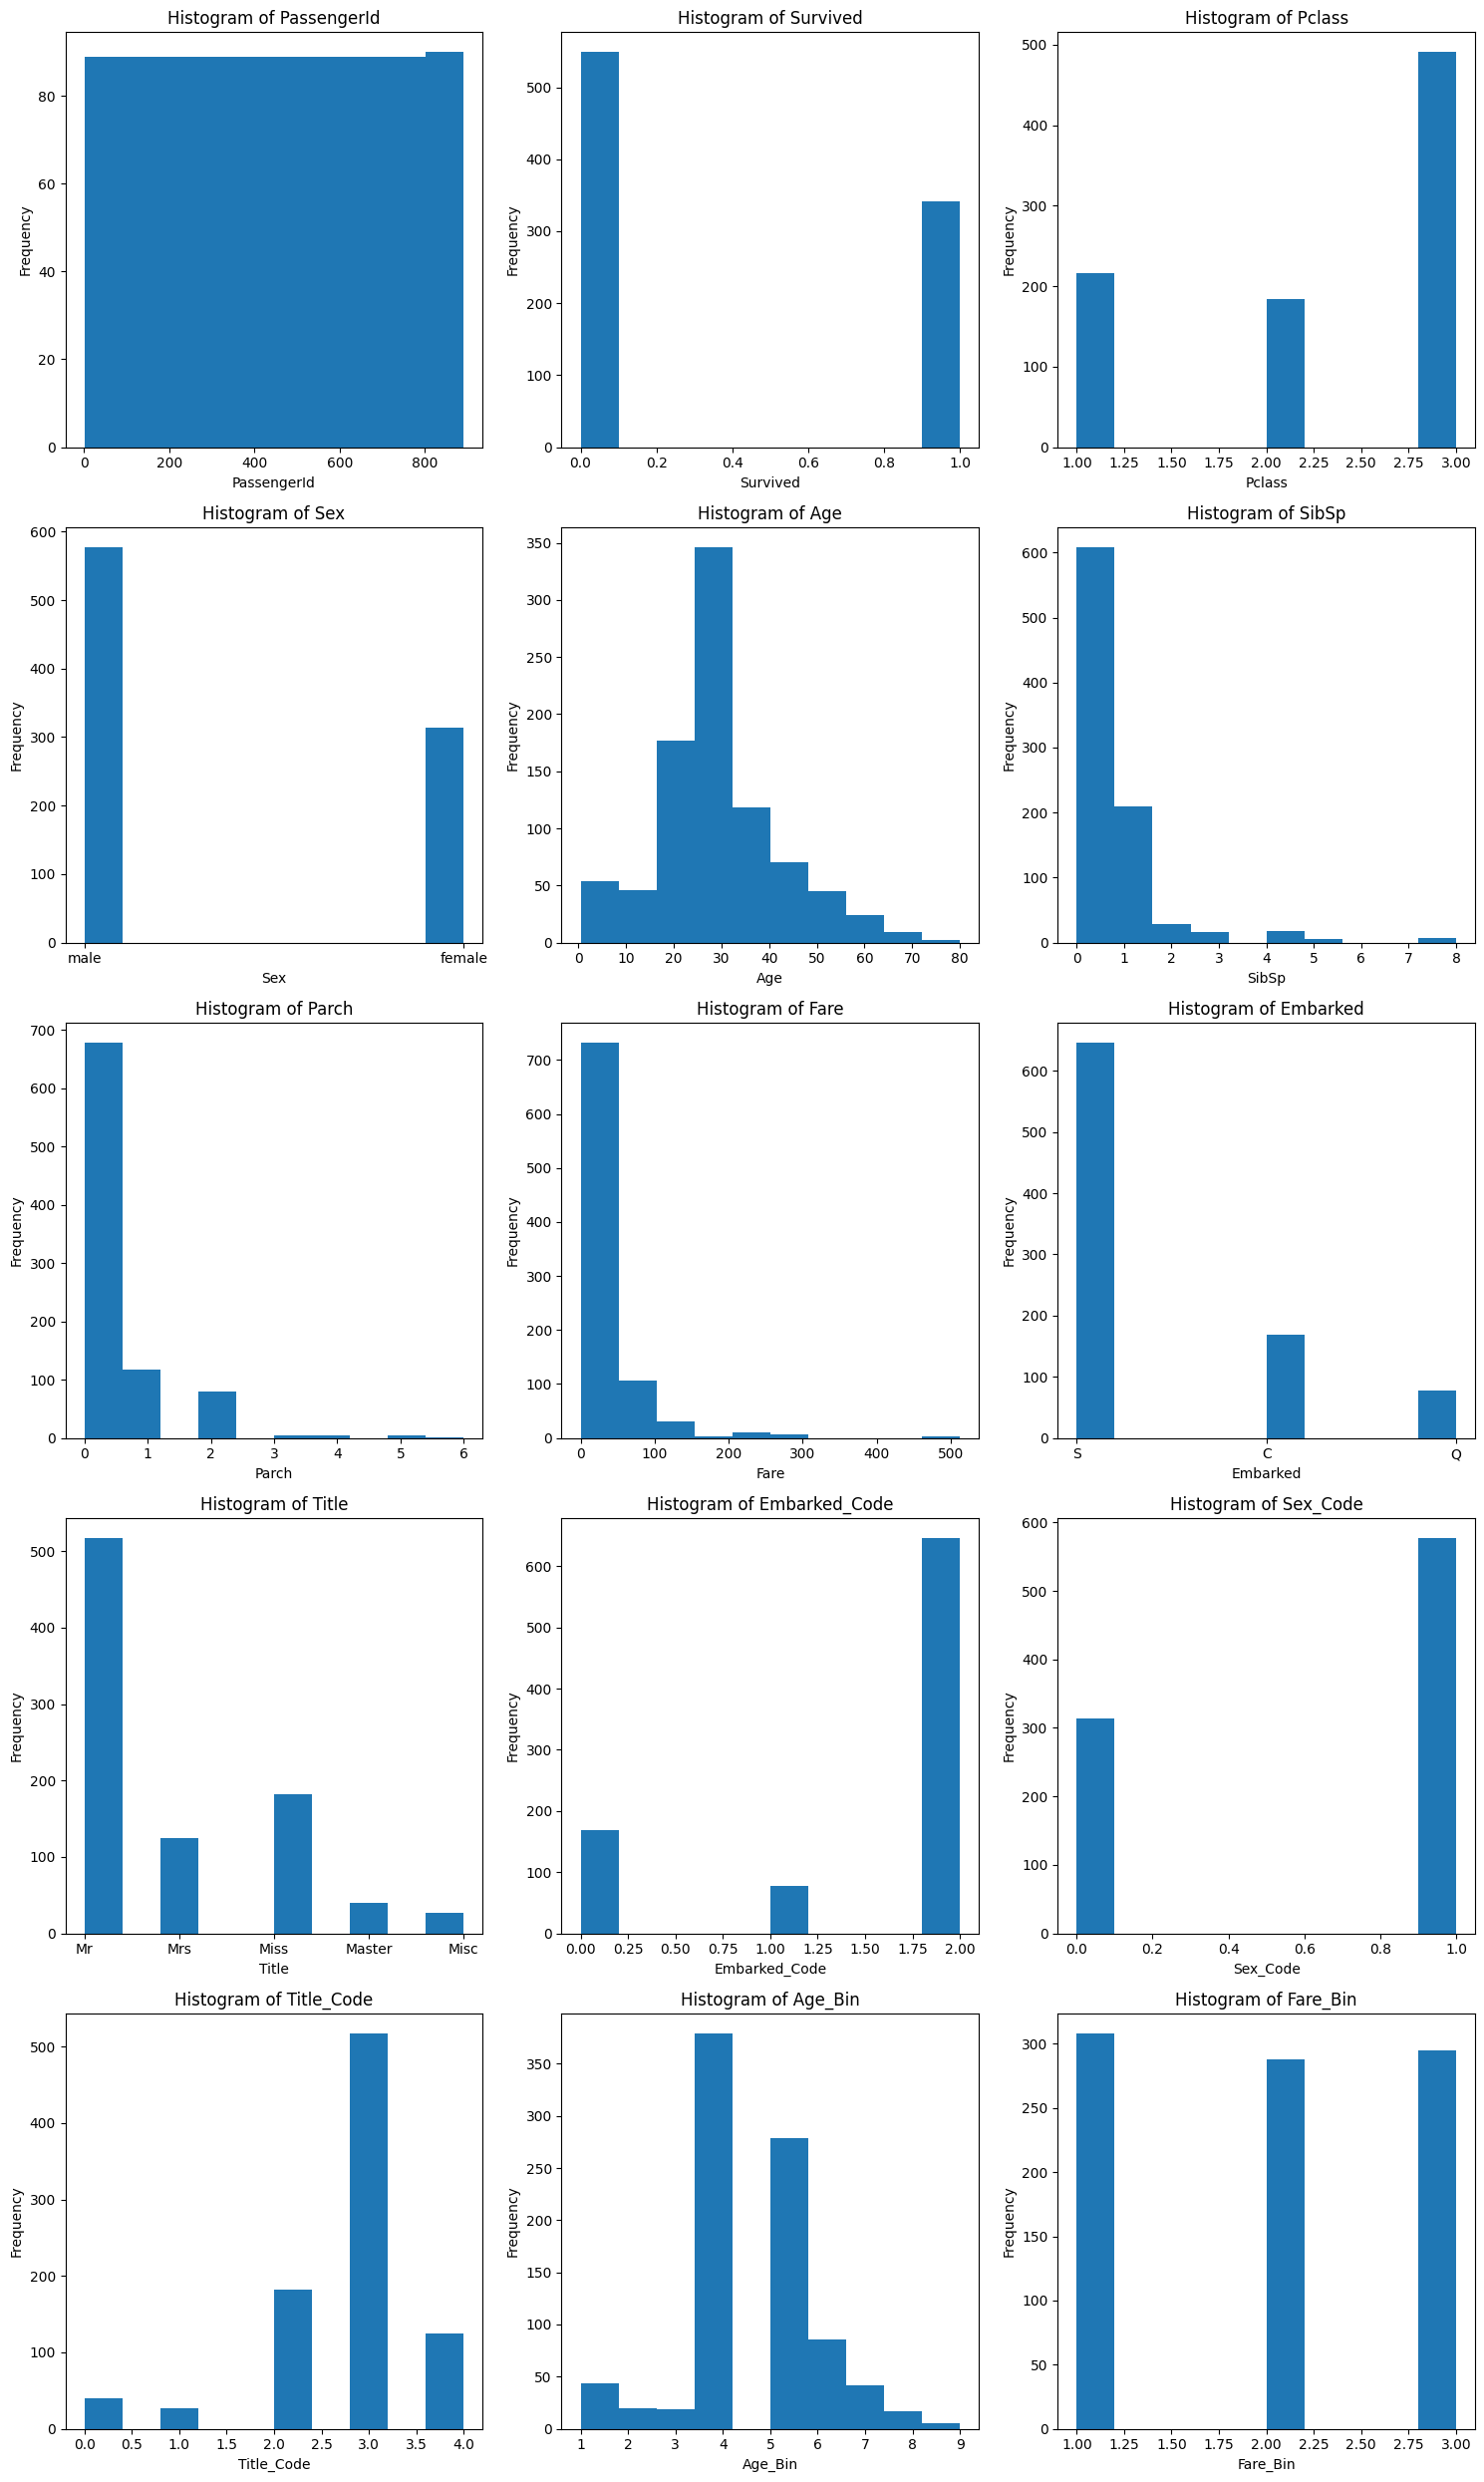

In [229]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    df[column].hist(ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots, num_rows*3):
        fig.delaxes(axes[i // 3, i % 3])

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)


In [230]:
df.dtypes

PassengerId        int64
Survived           int64
Pclass             int64
Sex               object
Age              float64
SibSp              int64
Parch              int64
Fare             float64
Embarked          object
Title             object
Embarked_Code      int64
Sex_Code           int64
Title_Code         int64
Age_Bin            int64
Fare_Bin           int64
dtype: object

In [231]:
df['Child'] = ((df['Age'] < 16)).astype(int)
df['Elder'] = ((df['Age'] > 60)).astype(int)


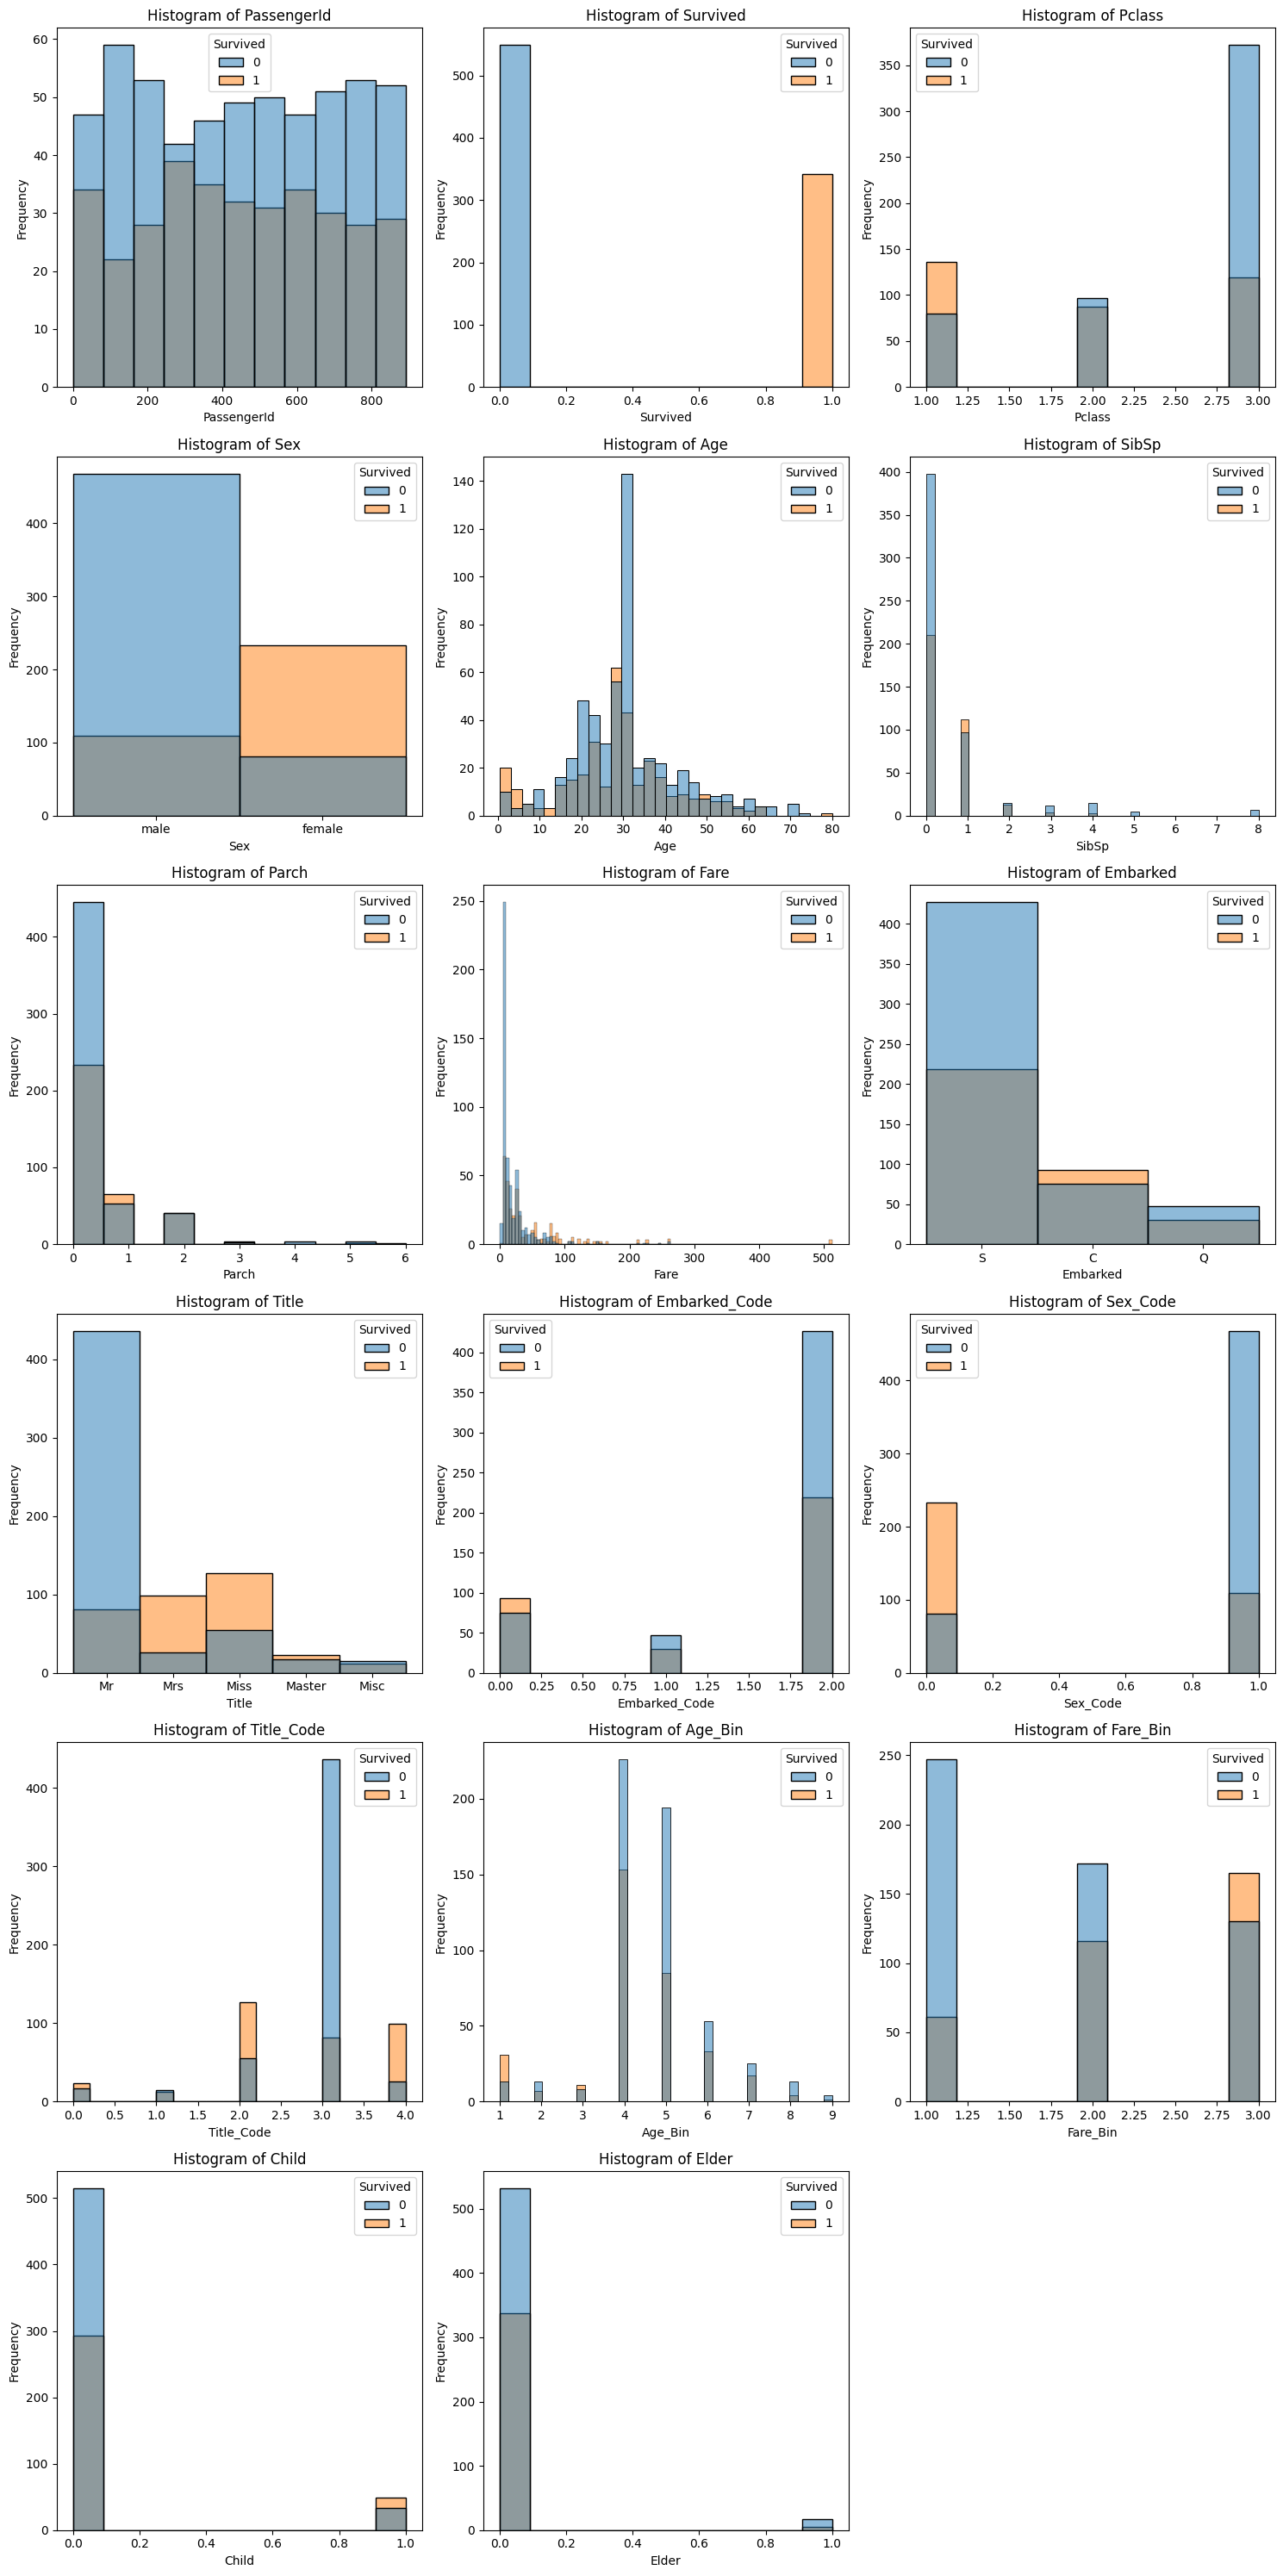

In [232]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.histplot(data=df, x=column, hue='Survived', ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots, num_rows*3):
        fig.delaxes(axes[i // 3, i % 3])

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

In [233]:
df_men = df[df['Sex']=='male']

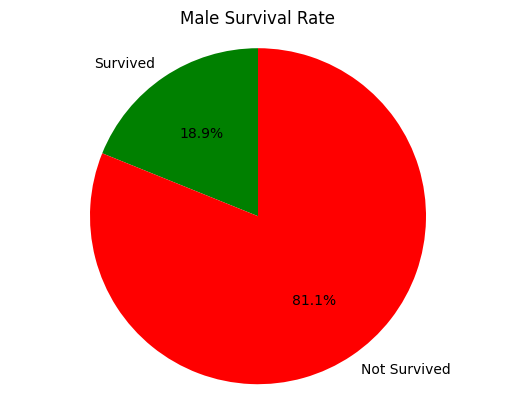

In [234]:
# Count the number of males who survived and did not survive
male_survived = len(df_men[df_men['Survived'] == 1])
male_not_survived = len(df_men[df_men['Survived'] == 0])

# Create a pie chart
labels = ['Survived', 'Not Survived']
sizes = [male_survived, male_not_survived]
colors = ['green', 'red']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Male Survival Rate')
plt.show()



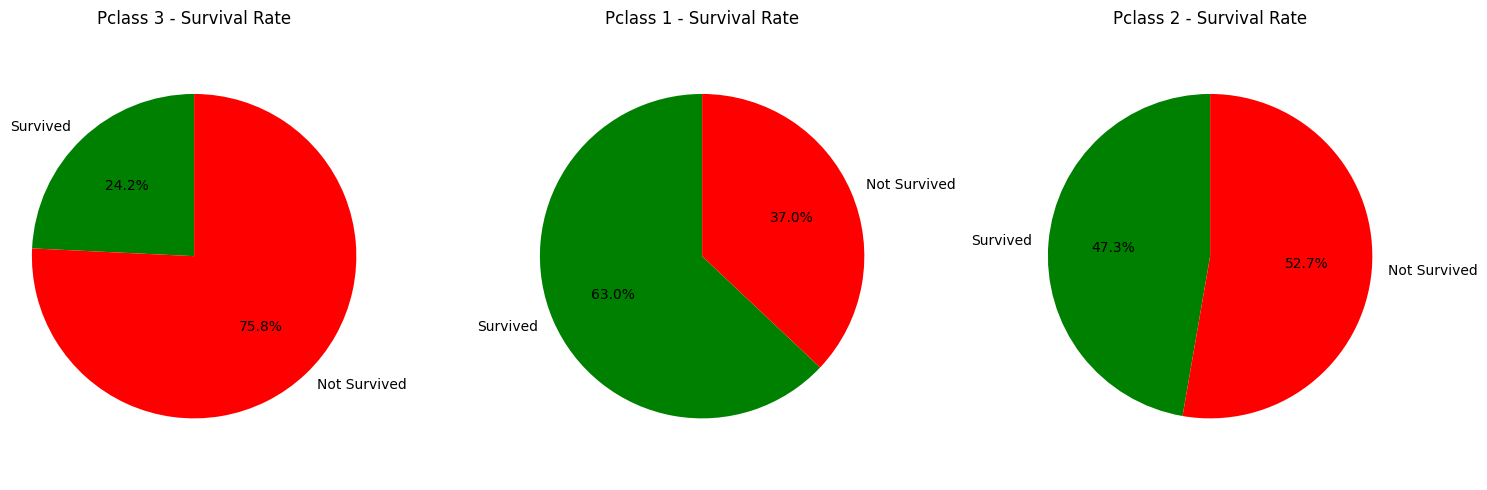

In [235]:
survived_percentage = df.groupby('Pclass')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, pclass in enumerate(df['Pclass'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Pclass {pclass} - Survival Rate')

plt.tight_layout()
plt.show()


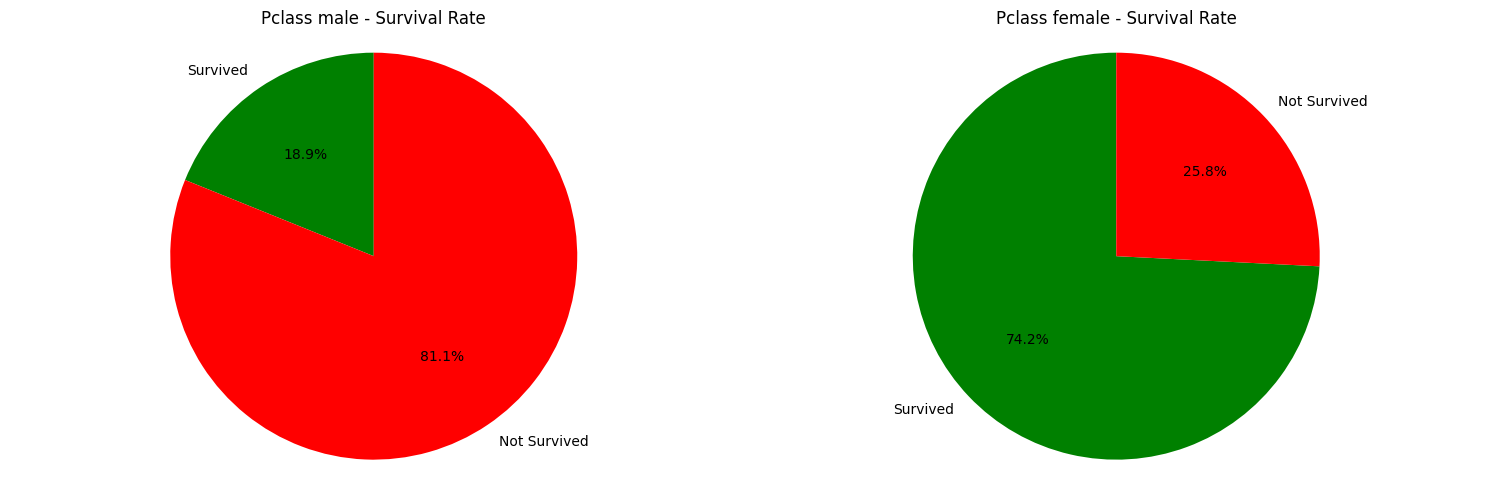

In [236]:
survived_percentage = df.groupby('Sex')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Iterate over each Pclass
for i, pclass in enumerate(df['Sex'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Pclass {pclass} - Survival Rate')

plt.tight_layout()
plt.show()

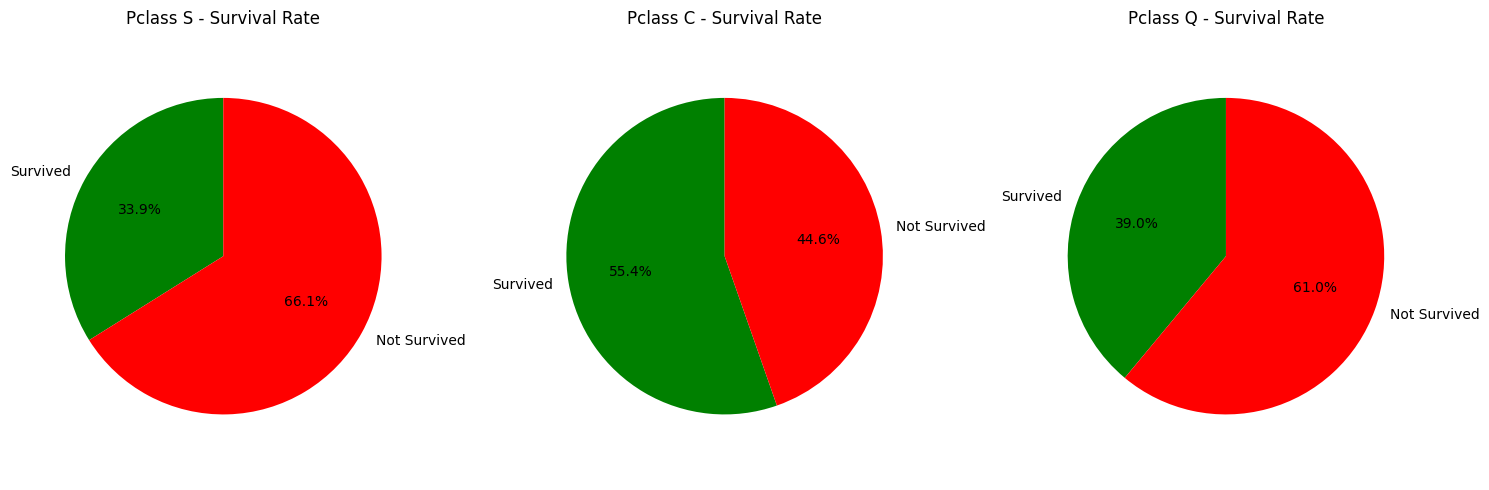

In [237]:
survived_percentage = df.groupby('Embarked')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, pclass in enumerate(df['Embarked'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Pclass {pclass} - Survival Rate')

plt.tight_layout()
plt.show()

In [238]:
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Misc'], dtype=object)

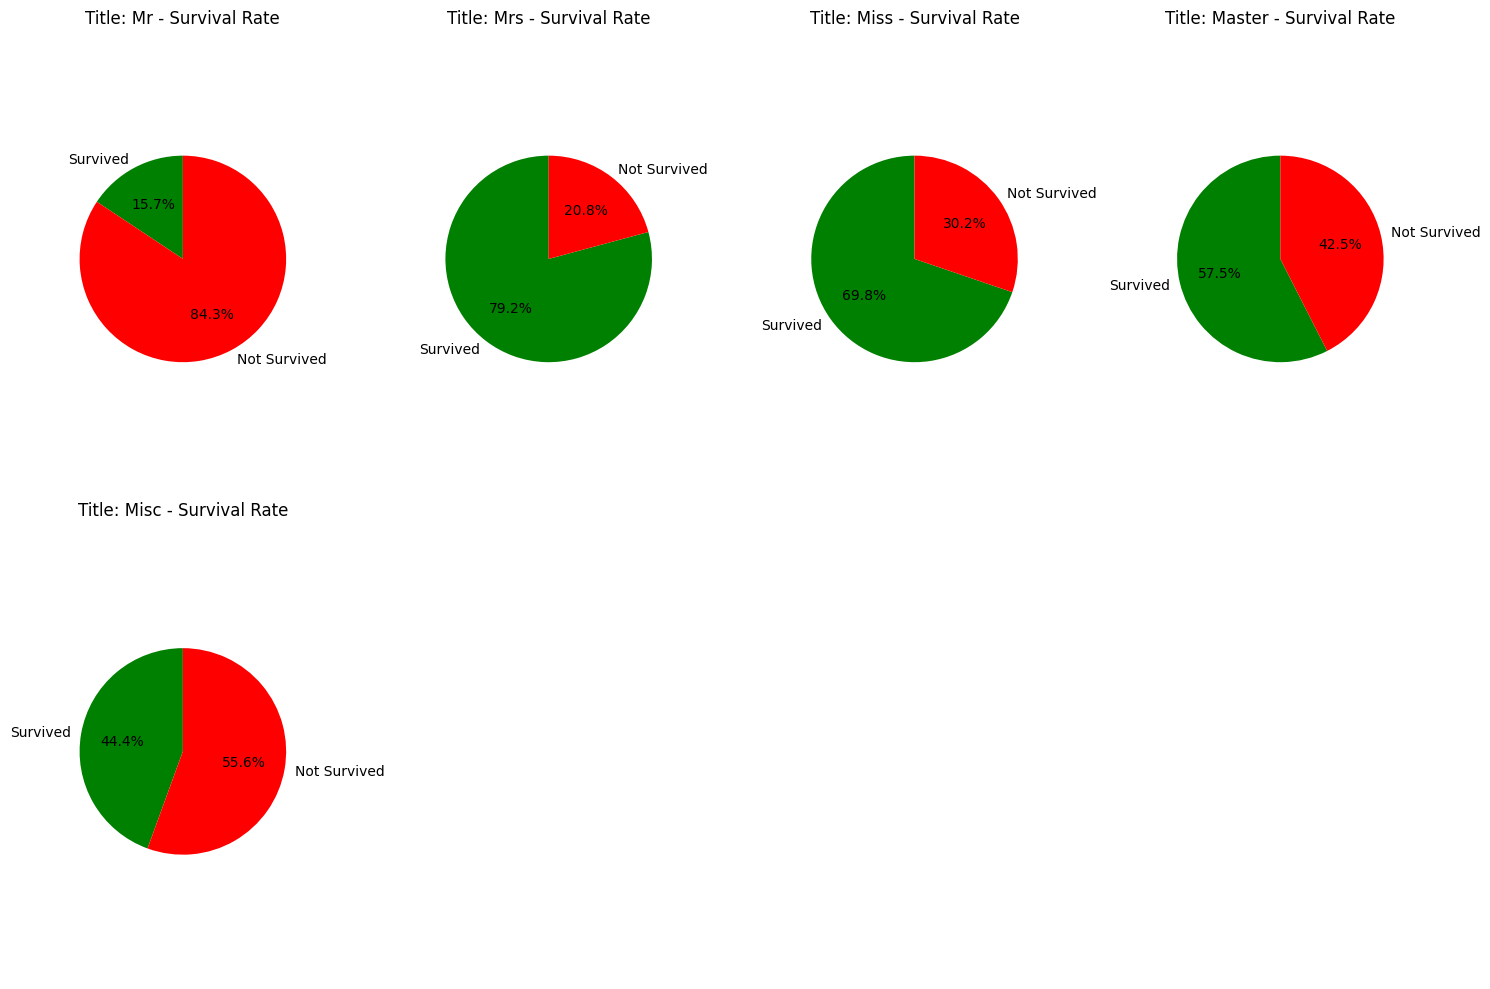

In [239]:
survived_percentage = df.groupby('Title')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(2, 4, figsize=(15, 10))

for i, title in enumerate(df['Title'].unique()):
    row = i // 4
    col = i % 4
    
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[title], not_survived_percentage[title]]
    colors = ['green', 'red']
    
    ax = axes[row, col]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Title: {title} - Survival Rate')
    
# Remove empty subplots
if len(df['Title'].unique()) < 8:
    for i in range(len(df['Title'].unique()), 8):
        fig.delaxes(axes[1, i % 4])

plt.tight_layout()


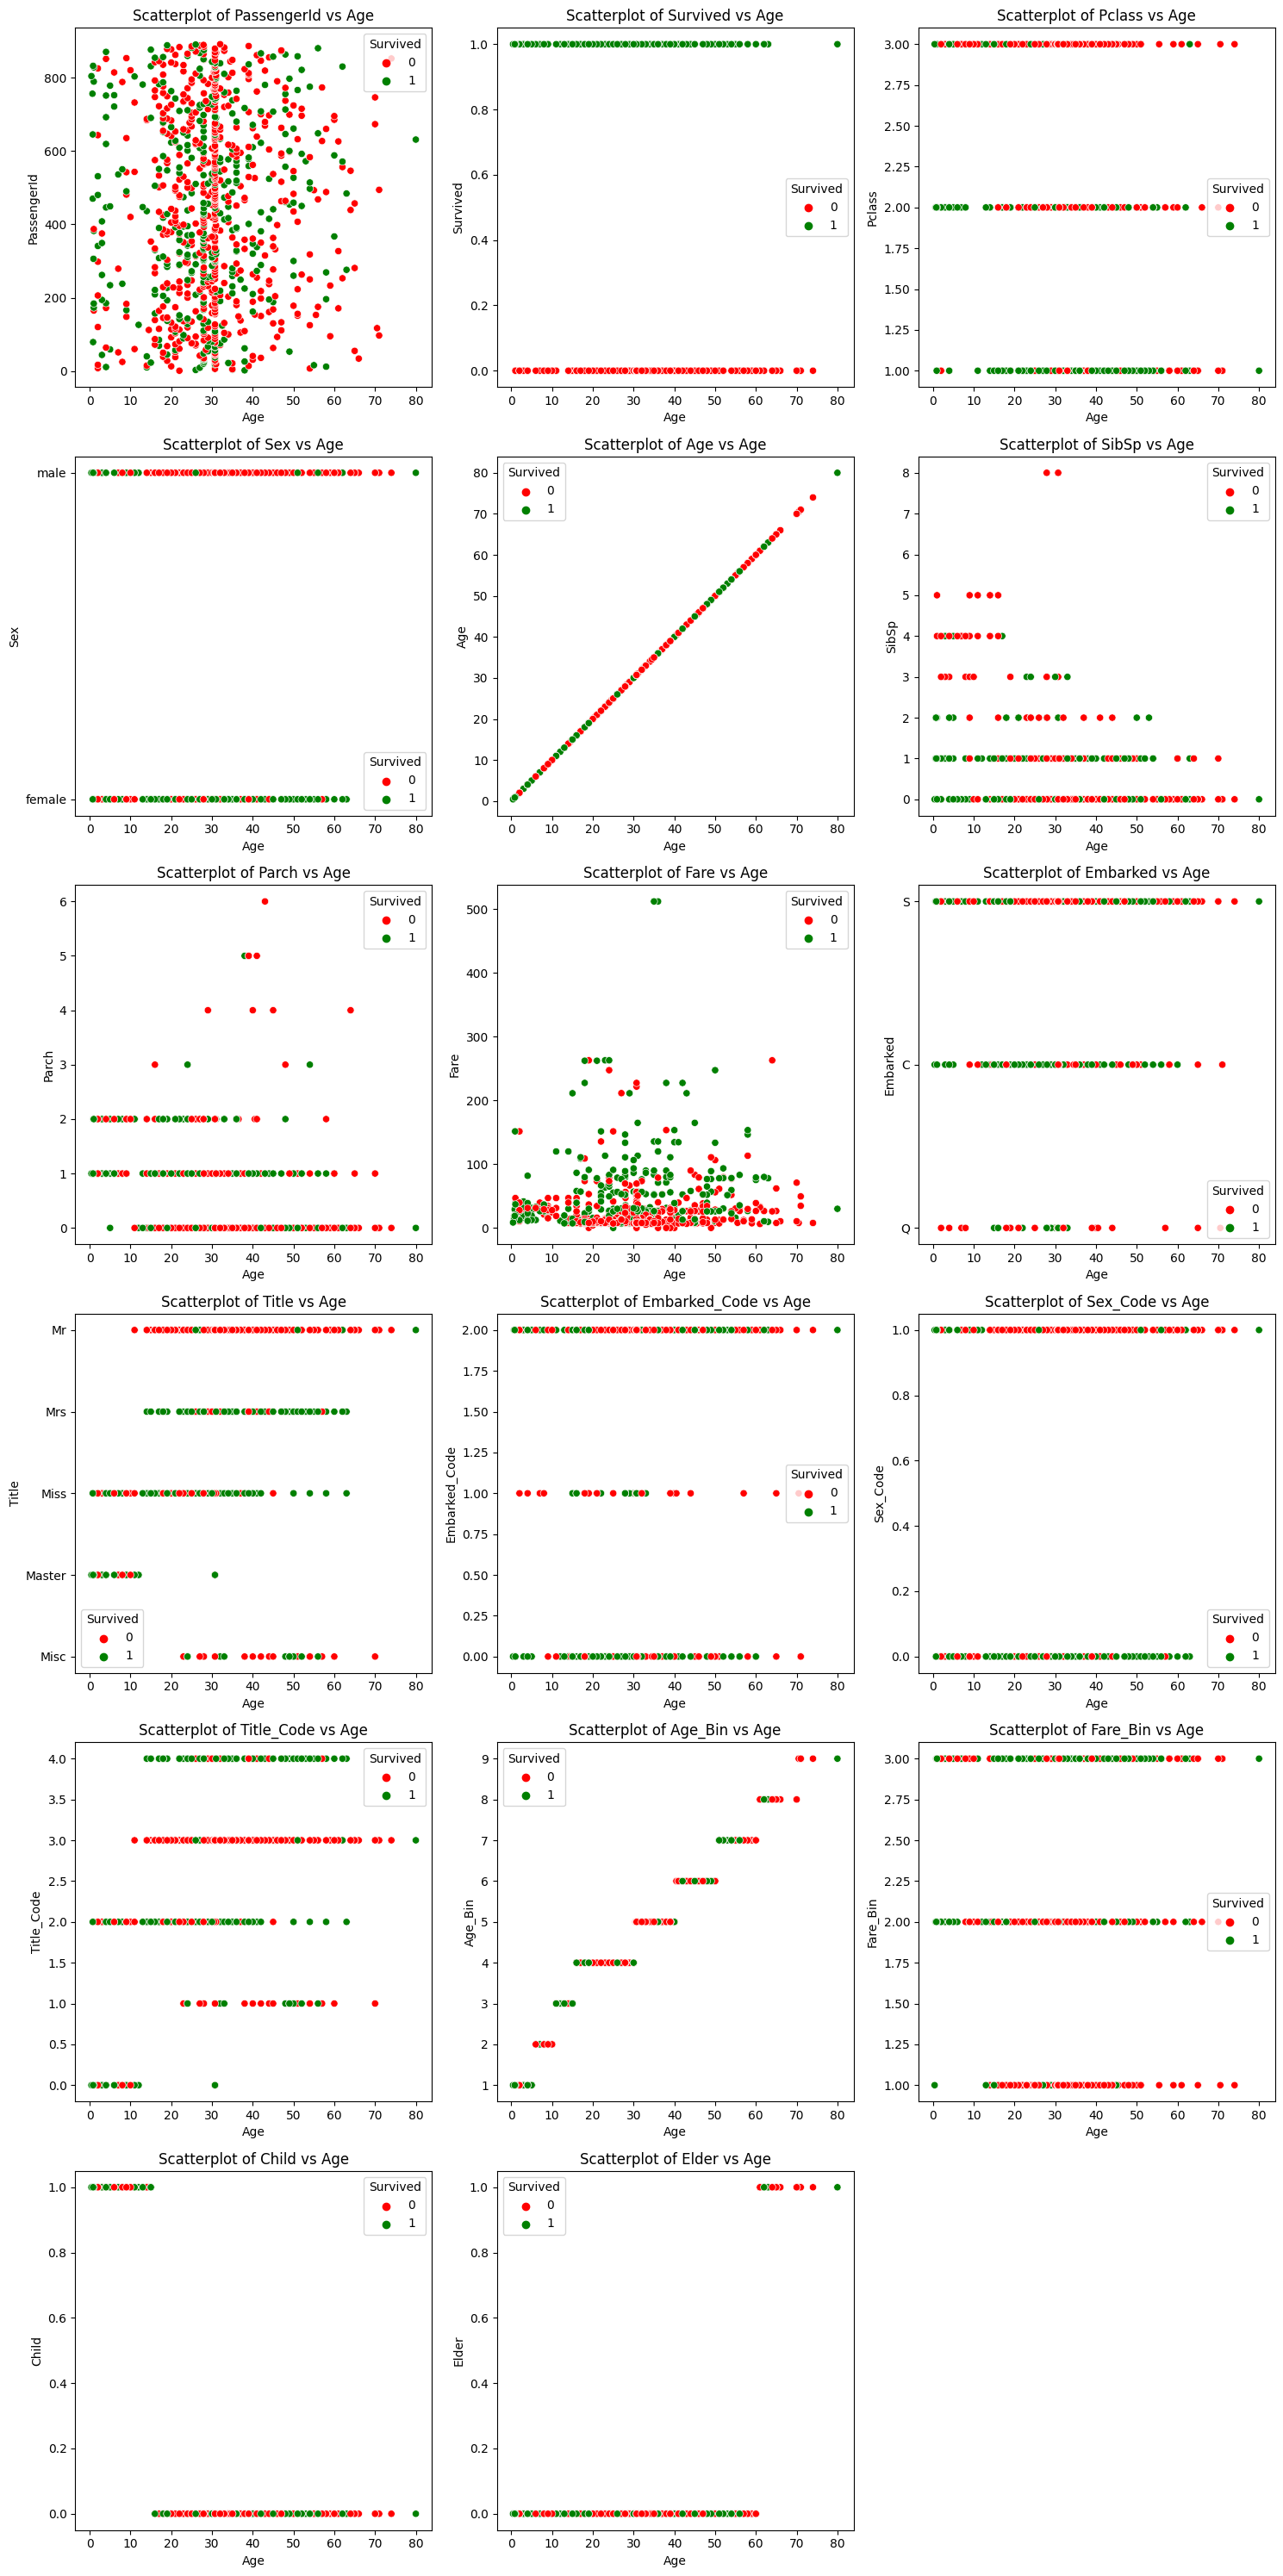

In [240]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.scatterplot(data=df, x='Age', y=column, hue='Survived', palette=['red', 'green'], ax=ax)
    ax.set_xlabel('Age')
    ax.set_ylabel(column)
    ax.set_title(f'Scatterplot of {column} vs Age')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots, num_rows*3):
        fig.delaxes(axes[i // 3, i % 3])

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)


In [241]:
df_men = df[df['Sex']== 'male']
df_women = df[df['Sex']== 'female']
df_child = df[df['Child']== 1]
df_Elder = df[df['Elder']== 1]

In [242]:
print("Male Death Rate:", (len(df_men[df_men['Survived'] == 0]) / len(df_men)) * 100)
print("Female Death Rate:", (len(df_women[df_women['Survived'] == 0])/ len(df_women)) * 100)
print("Child Death Rate:", (len(df_child[df_child['Survived'] == 0])/ len(df_child)) * 100)
print("Elder Death Rate:", (len(df_Elder[df_Elder['Survived'] == 0])/ len(df_Elder)) * 100)

Male Death Rate: 81.10918544194108
Female Death Rate: 25.796178343949045
Child Death Rate: 40.963855421686745
Elder Death Rate: 77.27272727272727


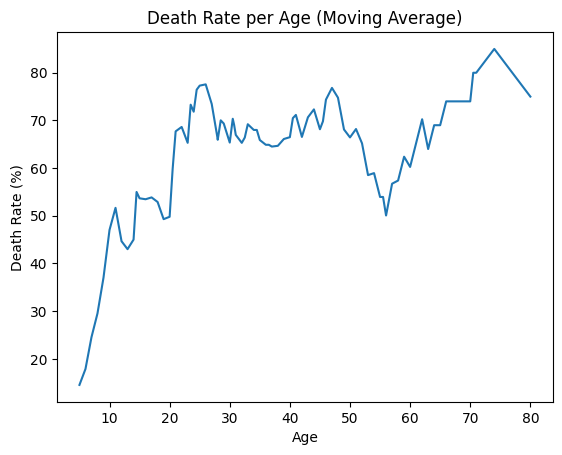

In [243]:
death_rate_per_age = df.groupby(['Age'])['Survived'].apply(lambda x: (x == 0).sum() / len(x) * 100)

moving_average = death_rate_per_age.rolling(window=10).mean()
plt.plot(death_rate_per_age.index, moving_average)
plt.xlabel('Age')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Age (Moving Average)')
plt.show()


<Axes: xlabel='Pclass', ylabel='Survived'>

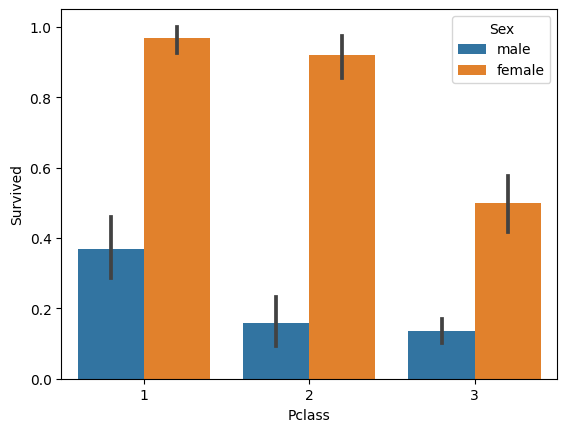

In [244]:
sns.barplot(data=df, x='Pclass', y='Survived',hue='Sex')


<Axes: xlabel='Parch', ylabel='Survived'>

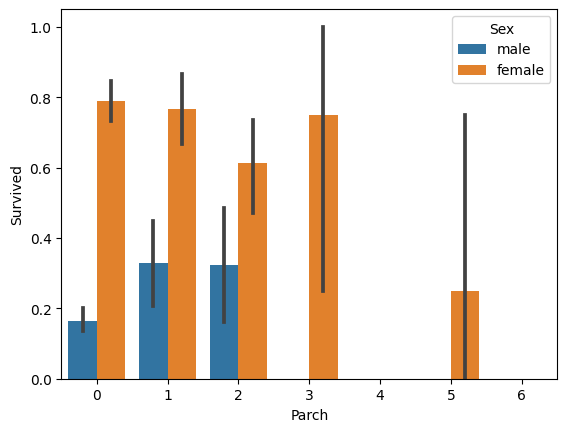

In [245]:
sns.barplot(data=df, x='Parch', y='Survived',hue='Sex')

In [246]:
df['Fam_Size'] = df['SibSp'] + df['Parch'] + 1

<Axes: xlabel='Fam_Size', ylabel='Survived'>

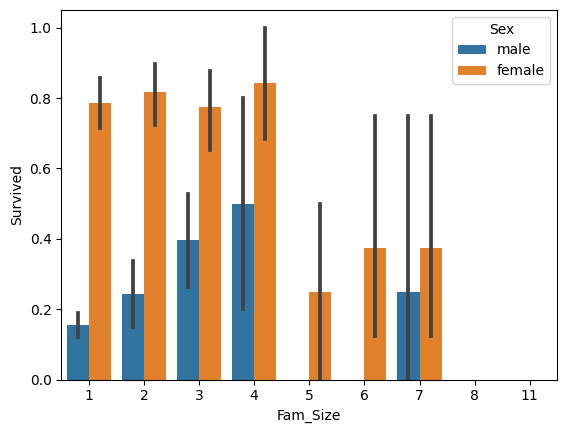

In [247]:
sns.barplot(data=df, x='Fam_Size', y='Survived',hue='Sex')

<Axes: xlabel='Title', ylabel='Survived'>

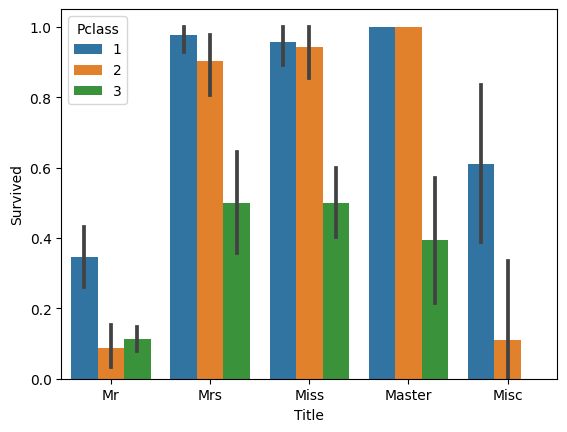

In [248]:
sns.barplot(data=df, x='Title', y='Survived', hue='Pclass')

<Axes: xlabel='Age_Bin', ylabel='Survived'>

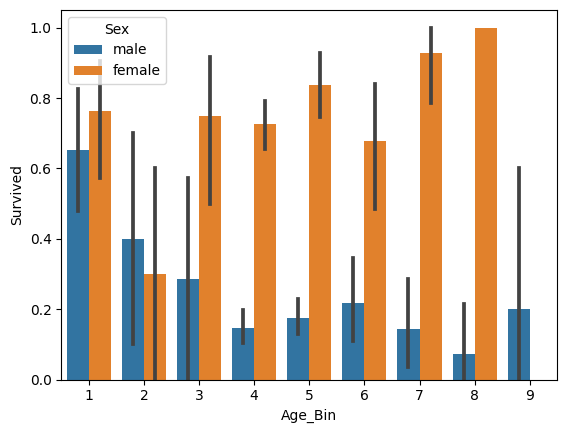

In [249]:
sns.barplot(data=df, x='Age_Bin', y='Survived',hue='Sex')

In [250]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'Title', 'Embarked_Code', 'Sex_Code', 'Title_Code',
       'Age_Bin', 'Fare_Bin', 'Child', 'Elder', 'Fam_Size'],
      dtype='object')

In [251]:
average_survival_rate_per_pclass = df.groupby('Pclass')['Survived'].mean()
average_survival_rate_per_sex = df.groupby('Sex')['Survived'].mean()
average_survival_rate_per_title = df.groupby('Title')['Survived'].mean()
average_survival_rate_per_age_bin = df.groupby('Age_Bin')['Survived'].mean()
average_survival_rate_per_fare_bin = df.groupby('Fare_Bin')['Survived'].mean()
average_survival_rate_per_embarked = df.groupby('Embarked')['Survived'].mean()

In [252]:
df_survival_rate = df.copy()

In [253]:
df_survival_rate['Survival_Rate_Pclass'] = df_survival_rate['Pclass'].map(average_survival_rate_per_pclass)
df_survival_rate['Survival_Rate_Sex'] = df_survival_rate['Sex'].map(average_survival_rate_per_sex)
df_survival_rate['Survival_Rate_Title'] = df_survival_rate['Title'].map(average_survival_rate_per_title)
df_survival_rate['Survival_Rate_Age_Bin'] = df_survival_rate['Age_Bin'].map(average_survival_rate_per_age_bin)
df_survival_rate['Survival_Rate_Fare_Bin'] = df_survival_rate['Fare_Bin'].map(average_survival_rate_per_fare_bin)
df_survival_rate['Survival_Rate_Embarked'] = df_survival_rate['Embarked'].map(average_survival_rate_per_embarked)

df_survival_rate['Survival_Level_Pclass'] = pd.cut(df_survival_rate['Survival_Rate_Pclass'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Sex'] = pd.cut(df_survival_rate['Survival_Rate_Sex'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Title'] = pd.cut(df_survival_rate['Survival_Rate_Title'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Age_Bin'] = pd.cut(df_survival_rate['Survival_Rate_Age_Bin'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Fare_Bin'] = pd.cut(df_survival_rate['Survival_Rate_Fare_Bin'], bins=4, labels=[1, 2, 3, 4]).astype(int)
df_survival_rate['Survival_Level_Embarked'] = pd.cut(df_survival_rate['Survival_Rate_Embarked'], bins=4, labels=[1, 2, 3, 4]).astype(int)

df_survival_rate['Survival_Level_Sum'] = df_survival_rate[['Survival_Level_Pclass', 'Survival_Level_Sex', 'Survival_Level_Title', 'Survival_Level_Age_Bin', 'Survival_Level_Fare_Bin', 'Survival_Level_Embarked']].sum(axis=1)


In [254]:
df_survival_rate.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,...,Survival_Rate_Age_Bin,Survival_Rate_Fare_Bin,Survival_Rate_Embarked,Survival_Level_Pclass,Survival_Level_Sex,Survival_Level_Title,Survival_Level_Age_Bin,Survival_Level_Fare_Bin,Survival_Level_Embarked,Survival_Level_Sum
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,...,0.403694,0.198052,0.339009,1,1,1,2,1,1,7
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,...,0.304659,0.559322,0.553571,4,4,4,1,4,4,21
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,...,0.403694,0.198052,0.339009,1,4,4,2,1,1,13
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,...,0.304659,0.559322,0.339009,4,4,4,1,4,1,18
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,...,0.304659,0.198052,0.339009,1,1,1,1,1,1,6


In [255]:
df_survival_rate.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_Code,Sex_Code,Title_Code,...,Survival_Rate_Age_Bin,Survival_Rate_Fare_Bin,Survival_Rate_Embarked,Survival_Level_Pclass,Survival_Level_Sex,Survival_Level_Title,Survival_Level_Age_Bin,Survival_Level_Fare_Bin,Survival_Level_Embarked,Survival_Level_Sum
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.736034,0.523008,0.381594,32.204208,1.536476,0.647587,2.740741,...,0.383838,0.383838,0.383838,2.140292,2.057239,2.153760,1.803591,2.639731,1.565657,12.360269
std,257.353842,0.486592,0.836071,13.014897,1.102743,0.806057,49.693429,0.791503,0.477990,0.896379,...,0.093212,0.149226,0.083065,1.307482,1.433970,1.407817,0.763367,1.259282,1.174116,4.624234
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.200000,0.198052,0.339009,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,2.000000,...,0.304659,0.198052,0.339009,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200,2.000000,1.000000,3.000000,...,0.403694,0.402778,0.339009,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,12.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,3.000000,...,0.403694,0.559322,0.389610,3.000000,4.000000,4.000000,2.000000,4.000000,1.000000,16.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,2.000000,1.000000,4.000000,...,0.704545,0.559322,0.553571,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,23.000000


In [256]:
df = df.merge(df_survival_rate[['PassengerId', 'Survival_Level_Sum']], on='PassengerId', how='left')

In [257]:
df.drop(columns = 'PassengerId', inplace=True)

In [258]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_Code,Sex_Code,Title_Code,Age_Bin,Fare_Bin,Child,Elder,Fam_Size,Survival_Level_Sum
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.736034,0.523008,0.381594,32.204208,1.536476,0.647587,2.740741,4.537598,1.985410,0.093154,0.024691,1.904602,12.360269
std,0.486592,0.836071,13.014897,1.102743,0.806057,49.693429,0.791503,0.477990,0.896379,1.355592,0.822991,0.290811,0.155270,1.613459,4.624234
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,6.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,2.000000,4.000000,1.000000,0.000000,0.000000,1.000000,8.000000
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200,2.000000,1.000000,3.000000,4.000000,2.000000,0.000000,0.000000,1.000000,12.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,3.000000,5.000000,3.000000,0.000000,0.000000,2.000000,16.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,2.000000,1.000000,4.000000,9.000000,3.000000,1.000000,1.000000,11.000000,23.000000


In [259]:
df['Survival_Level_Rank'] = pd.qcut(df['Survival_Level_Sum'], q=4, labels=[1, 2, 3, 4]).astype(int)


<Axes: xlabel='Age_Bin', ylabel='Survived'>

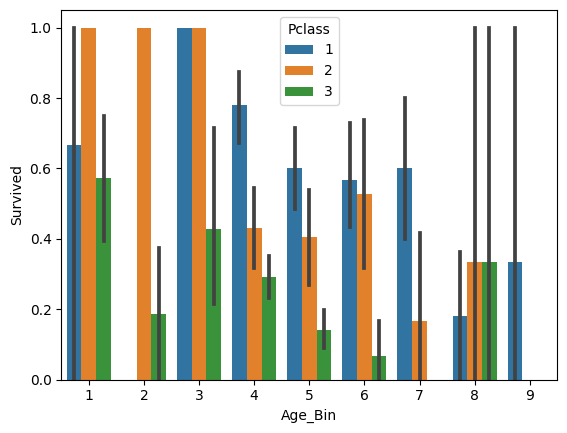

In [288]:
sns.barplot(data=df, x='Age_Bin', y='Survived',hue='Pclass')

<Axes: xlabel='Survival_Level_Sum', ylabel='Survived'>

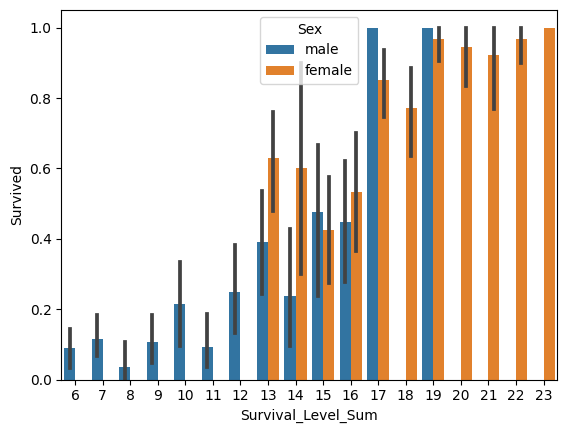

In [285]:
sns.barplot(data=df, x='Survival_Level_Sum', y='Survived',hue='Sex')

<Axes: xlabel='Survival_Level_Rank', ylabel='Survived'>

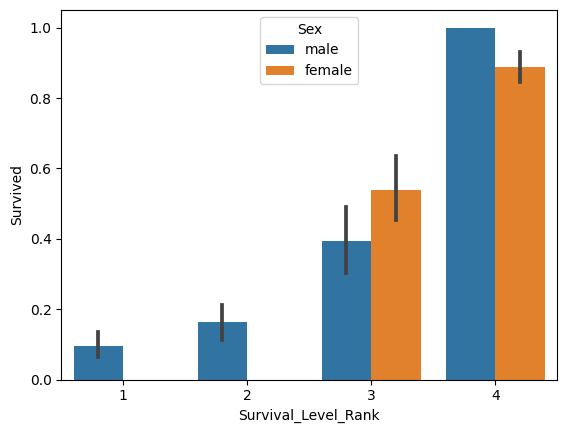

In [286]:
sns.barplot(data=df, x='Survival_Level_Rank', y='Survived',hue='Sex')

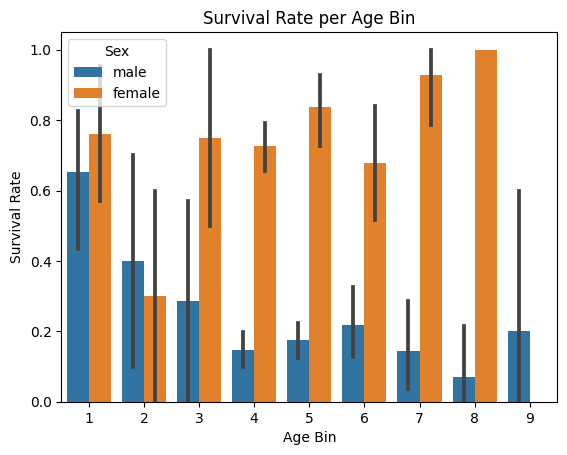

In [263]:
survival_rate_per_age_bin = df.groupby(['Sex', 'Age_Bin'])['Survived'].mean()

sns.barplot(data=df, x='Age_Bin', y='Survived', hue='Sex')
plt.xlabel('Age Bin')
plt.ylabel('Survival Rate')
plt.title('Survival Rate per Age Bin')
plt.show()


Text(0.5, 1.0, 'Age Distribution by Pclass and Sex')

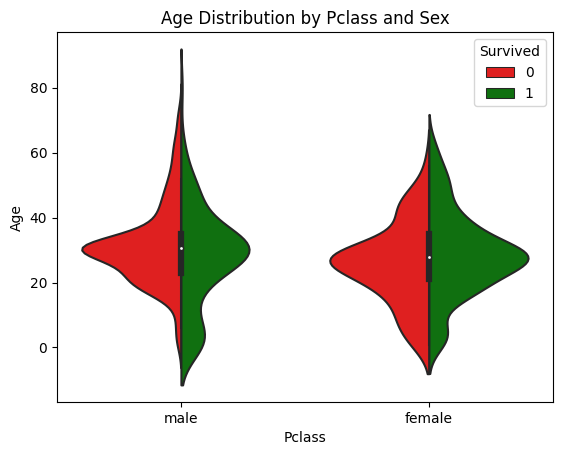

In [264]:
sns.violinplot(data=df, x='Sex', y='Age', hue='Survived', split=True, palette=['red', 'green'])
plt.xlabel('Pclass')
plt.ylabel('Age')
plt.title('Age Distribution by Pclass and Sex')


Text(0.5, 1.0, 'Age Distribution by Pclass and Sex')

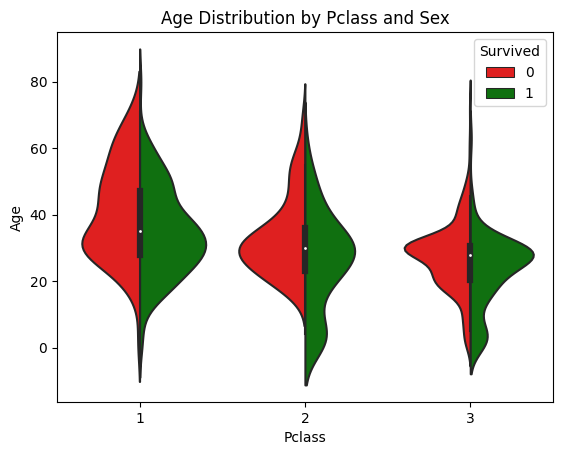

In [265]:
sns.violinplot(data=df, x='Pclass', y='Age', hue='Survived', split=True, palette=['red', 'green'])
plt.xlabel('Pclass')
plt.ylabel('Age')
plt.title('Age Distribution by Pclass and Sex')


Text(0.5, 1.0, 'Age Distribution by Pclass and Sex')

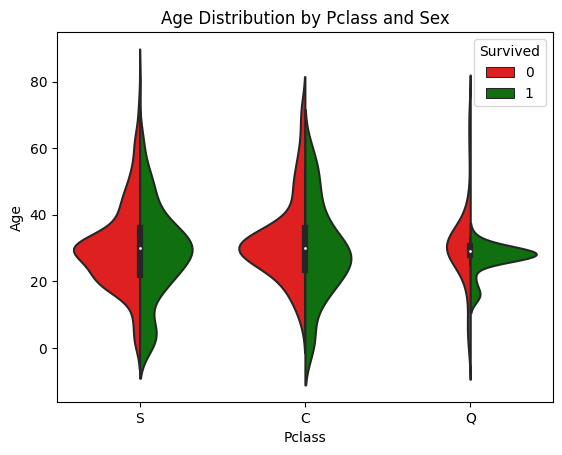

In [266]:
sns.violinplot(data=df, x='Embarked', y='Age', hue='Survived', split=True, palette=['red', 'green'])
plt.xlabel('Pclass')
plt.ylabel('Age')
plt.title('Age Distribution by Pclass and Sex')

In [267]:
death_rate_per_SibSp = df.groupby('SibSp')['Survived'].apply(lambda x: (x == 0).sum() / len(x)*100)
print(death_rate_per_SibSp)

SibSp
0     65.460526
1     46.411483
2     53.571429
3     75.000000
4     83.333333
5    100.000000
8    100.000000
Name: Survived, dtype: float64


In [268]:
df['Alone'] = ((df['Fam_Size'] == 1)).astype(int)
df['Big_Fam'] = ((df['Fam_Size'] > 4)).astype(int)

In [269]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Embarked_Code,...,Title_Code,Age_Bin,Fare_Bin,Child,Elder,Fam_Size,Survival_Level_Sum,Survival_Level_Rank,Alone,Big_Fam
0,0,3,male,22.0,1,0,7.2500,S,Mr,2,...,3,4,1,0,0,2,7,1,0,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs,0,...,4,5,3,0,0,2,21,4,0,0
2,1,3,female,26.0,0,0,7.9250,S,Miss,2,...,2,4,1,0,0,1,13,3,1,0
3,1,1,female,35.0,1,0,53.1000,S,Mrs,2,...,4,5,3,0,0,2,18,4,0,0
4,0,3,male,35.0,0,0,8.0500,S,Mr,2,...,3,5,1,0,0,1,6,1,1,0


Main takeaways so far: Being a 3rd class adult male with a large family size, or traveling alone, has a dramatically higher chance of death.

/var/folders/4r/t2pxznrn4dz28d6ymprq1p9c0000gn/T/ipykernel_3010/2610041125.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


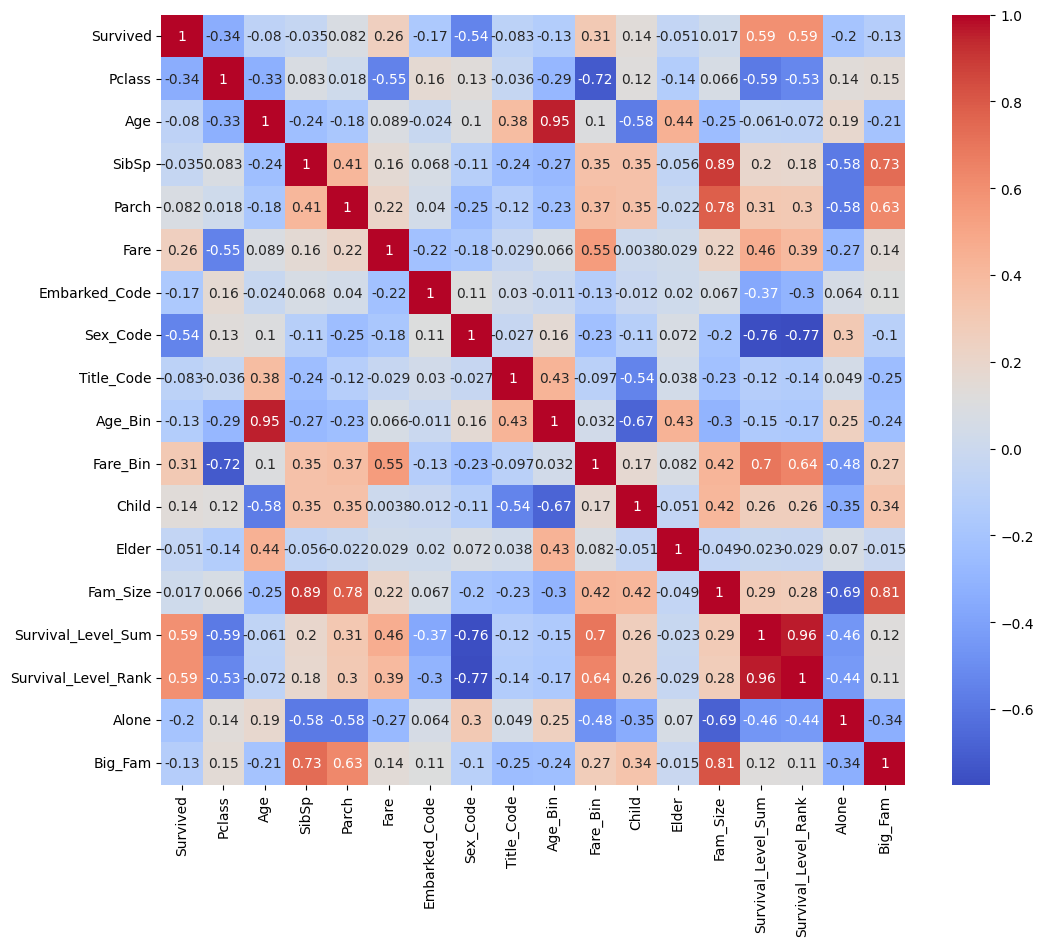

In [270]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [271]:
survived_correlation = correlation_matrix['Survived'].sort_values(ascending=False)
print(survived_correlation)


Survived               1.000000
Survival_Level_Rank    0.594900
Survival_Level_Sum     0.591124
Fare_Bin               0.305799
Fare                   0.257307
Child                  0.136107
Parch                  0.081629
Fam_Size               0.016639
SibSp                 -0.035322
Elder                 -0.051224
Age                   -0.080453
Title_Code            -0.083292
Big_Fam               -0.125147
Age_Bin               -0.134327
Embarked_Code         -0.167675
Alone                 -0.203367
Pclass                -0.338481
Sex_Code              -0.543351
Name: Survived, dtype: float64


In [272]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title', 'Embarked_Code', 'Sex_Code', 'Title_Code',
       'Age_Bin', 'Fare_Bin', 'Child', 'Elder', 'Fam_Size',
       'Survival_Level_Sum', 'Survival_Level_Rank', 'Alone', 'Big_Fam'],
      dtype='object')

In [275]:
cat_columns = ['Pclass', 'Sex_Code', 'Embarked_Code', 'Child', 'Elder', 'Age_Bin', 'Alone', 'Big_Fam', 'Title_Code', 'Fare_Bin', 'Survival_Level_Rank']
num_columns = ['Parch']
target = 'Survived'

In [276]:
X_train_temp, X_test_valid, y_train_temp, y_test_valid = train_test_split(df[cat_columns + num_columns], df[target], test_size=0.3, random_state=42)

# Second split: Split the 20% into testing and validation (50% each of 20% -> 10% each of total data)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=42)

In [277]:
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_columns), ('num', num_transformer, num_columns)])

In [278]:
X_train_transformed = preprocessor.fit_transform(X_train_temp)
X_test_transformed = preprocessor.transform(X_test)
X_valid_transformed = preprocessor.transform(X_valid)

In [279]:
param_grid = {'C': [0.1, 1, 10, 100], 'max_iter': [5000, 10000], 'dual': [False, True]}

grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

best_linear_model = grid_search.best_estimator_


linear_predict_test = best_linear_model.predict(X_test_transformed)
print("Test set accuracy:",metrics.accuracy_score(y_test, linear_predict_test))
print("Test set F1 score:",f1_score(y_test, linear_predict_test))
print("Test set AUC score:",roc_auc_score(y_test, linear_predict_test))


linear_predict_valid = best_linear_model.predict(X_valid_transformed)
linear_accuracy_score_valid =  metrics.accuracy_score(y_valid, linear_predict_valid)
linear_f1_score_valid = f1_score(y_valid, linear_predict_valid)
linear_auc_score_valid = roc_auc_score(y_valid, linear_predict_valid)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increas

Best parameters found: {'C': 1, 'dual': False, 'max_iter': 5000}
Test set accuracy: 0.8507462686567164
Test set F1 score: 0.8305084745762712
Test set AUC score: 0.8470982142857143


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [280]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train_temp)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)

best_rf_model = grid_search.best_estimator_
rf_predict_test = best_rf_model.predict(X_test_transformed)
print("Test set accuracy:",metrics.accuracy_score(y_test, rf_predict_test))
print("Test set F1 score:", f1_score(y_test, rf_predict_test))
print("Test set AUC score:",roc_auc_score(y_test, rf_predict_test))


rf_predict_valid = best_rf_model.predict(X_valid_transformed)
rf_accuracy_score_valid =  metrics.accuracy_score(y_valid, rf_predict_valid)
rf_f1_score_valid = f1_score(y_valid, rf_predict_valid)
rf_auc_score_valid = roc_auc_score(y_valid, rf_predict_valid)


Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Test set accuracy: 0.8656716417910447
Test set F1 score: 0.85
Test set AUC score: 0.8627232142857143


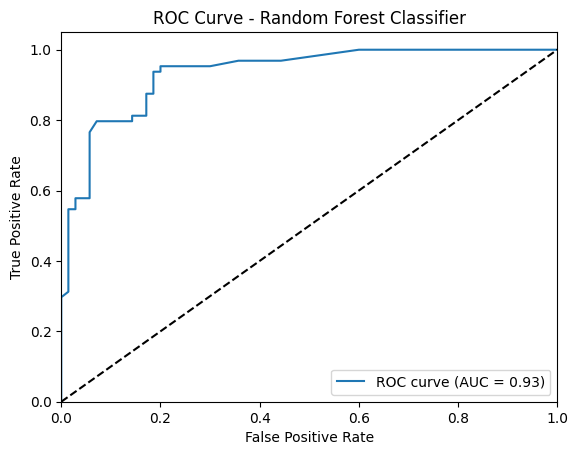

In [281]:
rf_predict_proba_test = best_rf_model.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_predict_proba_test)
rf_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % rf_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

In [282]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.01, 0.001]
}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)


best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_xgb_model = grid_search.best_estimator_

xgb_predict_test = best_xgb_model.predict(X_test_transformed)


print(metrics.accuracy_score(y_test, xgb_predict_test))
print(f1_score(y_test, xgb_predict_test))
print(roc_auc_score(y_test, xgb_predict_test))


xgb_predict_valid = best_xgb_model.predict(X_valid_transformed)
xgb_accuracy_score_valid =  metrics.accuracy_score(y_valid, xgb_predict_valid)
xgb_f1_score_valid = f1_score(y_valid, xgb_predict_valid)
xgb_auc_score_valid = roc_auc_score(y_valid, xgb_predict_valid)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
0.8656716417910447
0.8448275862068965
0.8613839285714285


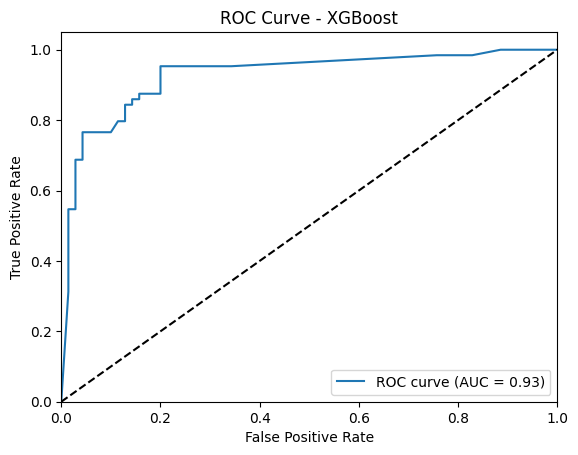

In [283]:
# ROC Curve and AUC for test set
xgb_predict_proba_test = best_xgb_model.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_predict_proba_test)
xgb_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % xgb_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

In [284]:
# Data description
print("Data description")
print("----------------")
# Number of examples
print("Number of examples")
print(f"train: {len(X_train_temp)}")
print(f"valid: {len(X_valid)}")
print(f"test: {len(X_test)}")
# Number of features
print(f"Number of features: {X_train_temp.shape[1]}")

# Number of examples per class (assuming binary classification)
print("\nNumber of examples per class")
print(f"class 0: {sum(y_train_temp == 0)}")
print(f"class 1: {sum(y_train_temp == 1)}")

# Descriptive statistics for features
print("\nDescriptive statistics")
print("----------------------")

# Calculate statistics for training dataset features
train_stats = X_train_temp.describe().transpose()

# Calculate statistics for validation dataset features
valid_stats = X_valid.describe().transpose()

# Calculate statistics for test dataset features
test_stats = X_test.describe().transpose()

# Print statistics for each dataset
for dataset_name, dataset_stats in zip(['Training', 'Validation', 'Test'], [train_stats, valid_stats, test_stats]):
    print(f"{dataset_name} dataset:")
    print(dataset_stats[['mean', '50%', 'std']])

# Results (you can add your model information here)
print("\nModel Results")
print("\n")

print("Model 1: Linear SVC")
print("----------------------------------")
print("Accuracy - Validation:", linear_accuracy_score_valid)
print("F1 Score - Validation:", linear_f1_score_valid)
print("AUC Score - Validation:", linear_auc_score_valid)
print("\n")

print("Model 2: Random Forest Classifier")
print("----------------------------------")
print("Accuracy - Validation:", rf_accuracy_score_valid)
print("F1 Score - Validation:", rf_f1_score_valid)
print("AUC Score - Validation:", rf_auc_score_valid)
print("\n")

print("Model 3: XGB Classifier")
print("----------------------------------")
print("Accuracy - Validation:", xgb_accuracy_score_valid)
print("F1 Score - Validation:", xgb_f1_score_valid)
print("AUC Score - Validation:", xgb_auc_score_valid)

Data description
----------------
Number of examples
train: 623
valid: 134
test: 134
Number of features: 12

Number of examples per class
class 0: 392
class 1: 231

Descriptive statistics
----------------------
Training dataset:
                         mean  50%       std
Pclass               2.341894  3.0  0.819945
Sex_Code             0.658106  1.0  0.474725
Embarked_Code        1.558587  2.0  0.775024
Child                0.102729  0.0  0.303848
Elder                0.016051  0.0  0.125774
Age_Bin              4.497592  4.0  1.372529
Alone                0.597111  1.0  0.490873
Big_Fam              0.073836  0.0  0.261714
Title_Code           2.727127  3.0  0.903380
Fare_Bin             1.977528  2.0  0.817499
Survival_Level_Rank  2.402889  2.0  1.089171
Parch                0.386838  0.0  0.807692
Validation dataset:
                         mean  50%       std
Pclass               2.179104  2.5  0.891486
Sex_Code             0.649254  1.0  0.478994
Embarked_Code        1.477612  